In [1]:
!pip install flwr
!pip install flwr[simulation]
!pip install tensorflow[and-cuda]
!pip install tensorflow_datasets
!pip install matplotlib

  Using cached protobuf-4.25.2-cp37-abi3-manylinux2014_x86_64.whl (294 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.15.1 requires protobuf<4.24,>=3.19.6, but you have protobuf 4.25.2 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.2 which is incompatible.
  Using cached protobuf-4.23.4-cp37-abi3-manylinux2014_x86_64.whl (304 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.2
    Uninstalling protobuf-4.25.2:
      Successfully uninstalled protobuf-4.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sour

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
enable_tf_gpu_growth()
#https://medium.com/mlearning-ai/evaluating-federated-learning-from-felt-labs-on-mnist-dataset-cbe081b28786


# Data Processing

In [3]:
def getcifarData():
    (traindataset,testDataset),datasetinfo = tfds.load(
        'cifar10',
        split=['train','test'],
        shuffle_files= True,
        as_supervised= True,
        with_info= True
    )
    return traindataset,testDataset,datasetinfo

In [4]:
def dataset_to_numpy(dataset):
    features = []
    labels = []
    for image, label in tfds.as_numpy(dataset):
        features.append(image)
        labels.append(label)
    return np.array(features), np.array(labels)

def Splitset(intrain,intest):
    Train_images, Train_label = dataset_to_numpy(intrain)
    Test_images, Test_label = dataset_to_numpy(intest)
    return  Train_images, Train_label,Test_images, Test_label

def datanorm(data):
    return data/255

In [5]:
trainset,testset, info = getcifarData()
Train_images, Train_label,Test_images, Test_label = Splitset(trainset,testset)
Train_images_n = datanorm(Train_images)
Test_images_n = datanorm(Test_images)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteZHGCAF/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteZHGCAF/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


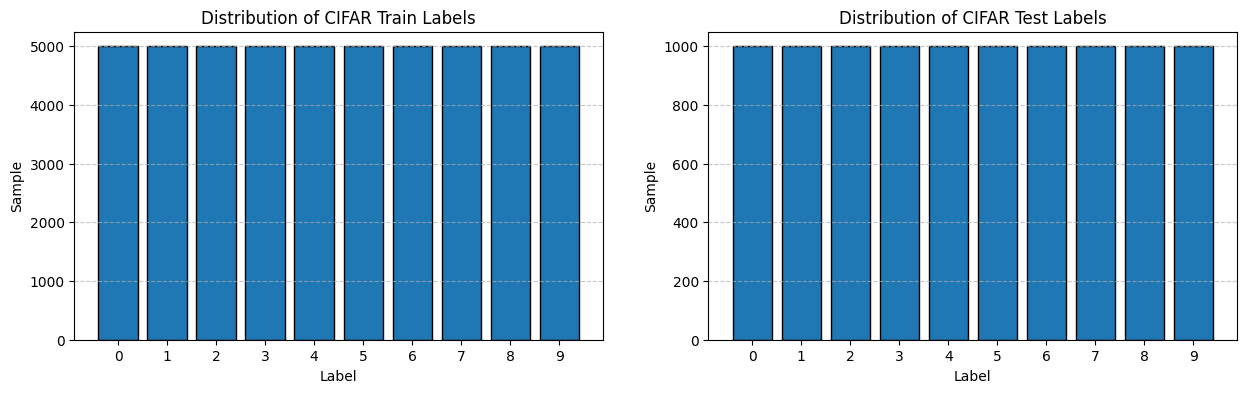

In [6]:
fig_1,axs_1 = plt.subplots(1,2,figsize = (15,4))
axs_1[0].hist(Train_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[0].set_title('Distribution of CIFAR Train Labels')
axs_1[0].set_xlabel('Label')
axs_1[0].set_ylabel('Sample')
axs_1[0].set_xticks(range(10))  # Digits 0 to 9
axs_1[0].grid(axis='y', linestyle='--', alpha=0.7)

axs_1[1].hist(Test_label, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black',label='Train')
axs_1[1].set_title('Distribution of CIFAR Test Labels')
axs_1[1].set_xlabel('Label')
axs_1[1].set_ylabel('Sample')
axs_1[1].set_xticks(range(10))  # Digits 0 to 9
axs_1[1].grid(axis='y', linestyle='--', alpha=0.7)


# Partition DataSet

In [7]:
def split_into_partition(data, labels, num_partitions):
    # Combine data and labels
    combined_data = list(zip(data, labels))
    np.random.shuffle(combined_data)  # Shuffle the combined data randomly

    partitions = [[] for _ in range(num_partitions)]
    store_label = np.unique(labels).tolist()
    counter = 0
    count = 0
    # Iterate over unique labels to efficiently distribute them across partitions
    while store_label:
        random_choice = np.random.choice(store_label)

        # Extract data and labels for the selected class
        class_data = [item[0] for item in combined_data if item[1] == random_choice]
        class_labels = [random_choice] * len(class_data)

        # Distribute the class data evenly among partitions
        modnum = len(np.unique(labels)) // num_partitions

        if counter == (num_partitions - 1):
            partitions[counter].extend(list(zip(class_data, class_labels)))
        elif count <= modnum:
            # Extend the selected partition with the data and labels
            count+=1
            partitions[counter].extend(list(zip(class_data, class_labels)))
            if count == modnum:
                counter += 1
                count=0


        store_label.remove(random_choice)

   # Separate data and labels after partitioning
    data_partitions = [np.array(list(zip(*partition))[0]) if partition else np.array([]) for partition in partitions]
    label_partitions = [np.array(list(zip(*partition))[1]) if partition else np.array([]) for partition in partitions]


    return data_partitions, label_partitions

In [8]:
NumOfPartition = 10
train_image_part,train_label_part = split_into_partition(Train_images_n,Train_label,NumOfPartition)

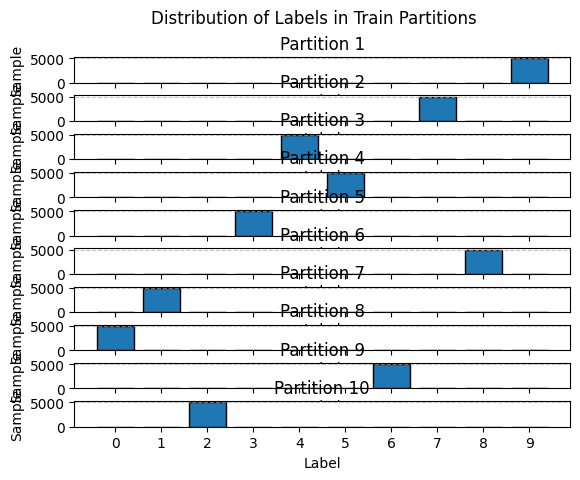

In [9]:
# Plot histogram for each partition
fig, axs = plt.subplots(NumOfPartition, sharex=True, sharey=True)

for i, partition in enumerate(train_label_part):
    axs[i].hist(partition, bins=range(11), align='left', rwidth=0.8, color='#1f77b4', edgecolor='black')
    axs[i].set_title(f'Partition {i + 1}')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Sample')
    axs[i].set_xticks(range(10))
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Labels in Train Partitions')
plt.show()

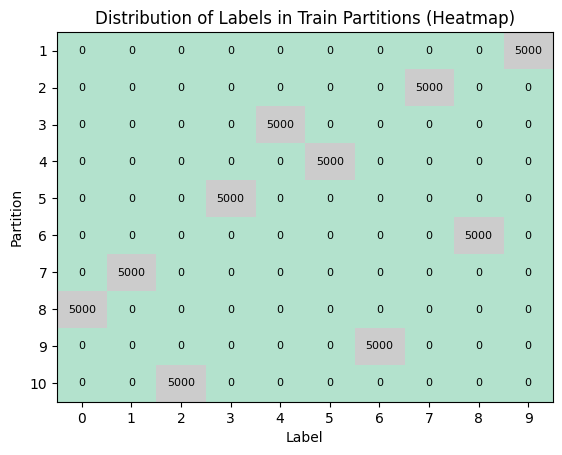

In [10]:
# Create an array to store the histogram data for each partition
hist_data = [np.histogram(partition, bins=range(11))[0] for partition in train_label_part]

# Plot heatmap
fig, ax = plt.subplots()
im = ax.imshow(hist_data, cmap='Pastel2',aspect='auto', interpolation='none')

# Add annotations
for i in range(len(train_label_part)):
    for j in range(10):
        text = ax.text(j, i, hist_data[i][j], ha='center', va='center', color='black', fontsize=8)

# Set labels and ticks
ax.set_title('Distribution of Labels in Train Partitions (Heatmap)')
ax.set_xlabel('Label')
ax.set_ylabel('Partition')
ax.set_xticks(range(10))
ax.set_yticks(range(len(train_label_part)))
ax.set_xticklabels(range(10))
ax.set_yticklabels(range(1, len(train_label_part) + 1))

# Add colorbar
plt.colorbar(im, ax=ax).remove()

plt.show()

In [11]:
def simpleRNNModel():
    model = keras.Sequential()
    model.add(keras.layers.Reshape((32, 32 * 3), input_shape=(32, 32, 3)))
    model.add(keras.layers.LSTM(128))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10,activation="softmax"))
    model.compile(optimizer=tf.keras.optimizers.Adam(),loss= "sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

# Client

In [12]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, train_x,train_y,val_x,val_y, model) -> None:
        super().__init__()
        self.train_feature_set = train_x
        self.train_label_set = train_y
        self.val_feature_set = val_x
        self.val_label_set = val_y
        self.model = model

    def get_parameters(self, config):
        return self.model.get_weights()
    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        print(f"round :{config['current_round']}")
        print(f"Train :{len(self.train_feature_set)}")
        print(f"Test :{len(self.val_feature_set)}")

        # Train the returned model
        TrainHistory = self.model.fit(x=self.train_feature_set,
                                 y=self.train_label_set,
                                 verbose=2,
                                 batch_size=config['batch_size'],
                                 epochs=config['local_epochs'],
                                 validation_data =(self.val_feature_set,self.val_label_set)
                                 )
        result ={
                "loss": TrainHistory.history['loss'][-1],
                "accuracy": round(TrainHistory.history['accuracy'][-1]*100,2),
                "val_loss" : TrainHistory.history['val_loss'][-1],
                "val_accuracy"  : round(TrainHistory.history["val_accuracy"][-1]*100,2),
        }

        print("Client Train and validate Done!!!")
        # Send local model to server to do aggreation
        return self.model.get_weights(), len(self.train_feature_set),result

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        # Test Global model
        loss, accuracy = self.model.evaluate(self.val_feature_set,
                                        self.val_label_set,
                                        batch_size=config['batch_size'],
                                        verbose=2)
        print("Global Validate Done!!!")
        return loss, len(self.val_feature_set), {"accuracy": round(float(accuracy*100),2)}


def generate_client_fn(train_x,train_y,val_x,val_y, model):
    """Return a function to construct a FlowerClient."""

    def client_fn(cid: str):
        print
        return FlowerClient(train_x[int(cid)],train_y[int(cid)],val_x,val_y,model)
    return client_fn


# Server

In [13]:
# config for Client using Server side
def fit_config(server_round: int):
    """Return training configuration dict for each round."""
    config = {
        "batch_size": 32,
        "current_round": server_round,
        "local_epochs": 10,
    }
    return config

def evalute_config(server_round: int):
    """Return test configuration dict for each round."""
    config = {
        "batch_size": 1,
        "current_round": server_round,
    }
    return config

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

def fit_average(metric):
    examples = [num_examples for num_examples, _ in metric]
    trainacc = [num_examples * m["accuracy"] for num_examples, m in metric]
    valacc = [num_examples * m["val_accuracy"] for num_examples, m in metric]

    return { "example": sum(examples),
            "accuracy": sum(trainacc) / sum(examples),
            "valacc": sum(valacc) / sum(examples)
            }





In [14]:
Fedavgconfig = fl.server.strategy.FedAvg(on_fit_config_fn=fit_config,
                                         on_evaluate_config_fn=evalute_config,
                                         evaluate_metrics_aggregation_fn=weighted_average,
                                         fit_metrics_aggregation_fn=fit_average,
                                         min_evaluate_clients= NumOfPartition,
                                         min_fit_clients=NumOfPartition,
                                         min_available_clients=NumOfPartition,
                                        )

# Simulation

In [15]:
globalmodel = simpleRNNModel()
clientfn = generate_client_fn(train_image_part,train_label_part,Test_images_n,Test_label,globalmodel)

In [18]:
history = fl.simulation.start_simulation(
        client_fn=clientfn,
        num_clients=NumOfPartition,
        config=fl.server.ServerConfig(num_rounds=10),
        strategy=Fedavgconfig,
        ray_init_args ={
            "include_dashboard": True, # we need this one for tracking,
        },
        actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth # <-- To be executed upon actor init.
    },
        client_resources = {'num_cpus': 2, 'num_gpus': 1}, # A Python dict specifying CPU/GPU resources
    )

INFO flwr 2024-02-12 03:44:47,154 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2024-02-12 03:44:54,016	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-12 03:44:55,968 | app.py:213 | Flower VCE: Ray initialized with resources: {'memory': 7870655694.0, 'object_store_memory': 3935327846.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 7870655694.0, 'object_store_memory': 3935327846.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'GPU': 1.0, 'node:172.28.0.12': 1.0}
INFO flwr 2024-02-12 03:44:55,972 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.htm

(DefaultActor pid=8846) round :1
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10


(DefaultActor pid=8846) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(DefaultActor pid=8846) I0000 00:00:1707709506.930093    8977 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0392 - accuracy: 0.9936 - val_loss: 10.2030 - val_accuracy: 0.1000 - 5s/epoch - 31ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.3053e-05 - accuracy: 1.0000 - val_loss: 10.8755 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.9312e-05 - accuracy: 1.0000 - val_loss: 11.3179 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.1988e-05 - accuracy: 1.0000 - val_loss: 11.6363 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.3052e-05 - accuracy: 1.0000 - val_loss: 11.8882 - val_accuracy: 0.1000 - 2s/epoch - 15ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.7648e-05 - accuracy: 1.0000 - val_loss: 12.1006 - val_accuracy: 0.1000 - 2s/e

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0250 - accuracy: 0.9980 - val_loss: 10.6414 - val_accuracy: 0.1000 - 5s/epoch - 34ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.5619e-05 - accuracy: 1.0000 - val_loss: 11.2428 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.1660e-05 - accuracy: 1.0000 - val_loss: 11.6585 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.1017e-05 - accuracy: 1.0000 - val_loss: 11.9789 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.5155e-05 - accuracy: 1.0000 - val_loss: 12.2435 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1505e-05 - accuracy: 1.0000 - val_loss: 12

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0298 - accuracy: 0.9962 - val_loss: 10.4145 - val_accuracy: 0.1000 - 4s/epoch - 27ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.1987e-05 - accuracy: 1.0000 - val_loss: 11.0779 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.9064e-05 - accuracy: 1.0000 - val_loss: 11.4926 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.5748e-05 - accuracy: 1.0000 - val_loss: 11.8075 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.8529e-05 - accuracy: 1.0000 - val_loss: 12.0675 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.4069e-05 - accuracy: 1.0000 - val_loss: 12

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :1
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0459 - accuracy: 0.9934 - val_loss: 9.9501 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0866e-04 - accuracy: 1.0000 - val_loss: 10.5638 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.1212e-05 - accuracy: 1.0000 - val_loss: 10.9749 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.0780e-05 - accuracy: 1.0000 - val_loss: 11.2872 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.9732e-05 - accuracy: 1.0000 - val_loss: 11.5403 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=88

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0283 - accuracy: 0.9940 - val_loss: 10.1803 - val_accuracy: 0.1000 - 5s/epoch - 34ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.0263e-05 - accuracy: 1.0000 - val_loss: 10.8355 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.8045e-05 - accuracy: 1.0000 - val_loss: 11.2908 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.0511e-05 - accuracy: 1.0000 - val_loss: 11.6432 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.1341e-05 - accuracy: 1.0000 - val_loss: 11.9290 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.5918e-05 - accuracy: 1.0000 - val_loss: 12

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0424 - accuracy: 0.9936 - val_loss: 10.1008 - val_accuracy: 0.1000 - 5s/epoch - 29ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.8051e-05 - accuracy: 1.0000 - val_loss: 10.7752 - val_accuracy: 0.1000 - 2s/epoch - 16ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.2059e-05 - accuracy: 1.0000 - val_loss: 11.2313 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.3287e-05 - accuracy: 1.0000 - val_loss: 11.5731 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.3554e-05 - accuracy: 1.0000 - val_loss: 11.8466 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.7739e-05 - accuracy: 1.0000 - val_loss: 12

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :1
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0389 - accuracy: 0.9936 - val_loss: 10.0251 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0950e-04 - accuracy: 1.0000 - val_loss: 10.6932 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.9207e-05 - accuracy: 1.0000 - val_loss: 11.1219 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 3.8599e-05 - accuracy: 1.0000 - val_loss: 11.4471 - val_accuracy: 0.1000 - 3s/epoch - 18ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.7563e-05 - accuracy: 1.0000 - val_loss: 11.7123 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :1
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0390 - accuracy: 0.9936 - val_loss: 10.0245 - val_accuracy: 0.1000 - 5s/epoch - 32ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.5336e-05 - accuracy: 1.0000 - val_loss: 10.8038 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.6592e-05 - accuracy: 1.0000 - val_loss: 11.2906 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.8971e-05 - accuracy: 1.0000 - val_loss: 11.6409 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.0355e-05 - accuracy: 1.0000 - val_loss: 11.9137 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :1
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0464 - accuracy: 0.9930 - val_loss: 9.7959 - val_accuracy: 0.1000 - 5s/epoch - 30ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.3083e-04 - accuracy: 1.0000 - val_loss: 10.4850 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.7899e-05 - accuracy: 1.0000 - val_loss: 10.9554 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.2694e-05 - accuracy: 1.0000 - val_loss: 11.3118 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.9770e-05 - accuracy: 1.0000 - val_loss: 11.6007 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=88

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :1
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0488 - accuracy: 0.9932 - val_loss: 10.0592 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.9475e-05 - accuracy: 1.0000 - val_loss: 10.7571 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.1309e-05 - accuracy: 1.0000 - val_loss: 11.2006 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.2883e-05 - accuracy: 1.0000 - val_loss: 11.5442 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.3197e-05 - accuracy: 1.0000 - val_loss: 11.8182 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8

DEBUG flwr 2024-02-12 03:48:41,223 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
DEBUG flwr 2024-02-12 03:48:41,260 | server.py:173 | evaluate_round 1: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 1: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 157/157 - 2s - loss: 7.9340e-06 - accuracy: 1.0000 - val_loss: 12.6977 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Client Train and validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3924 - accuracy: 0.1135 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3924 - accuracy: 0.1135 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3924 - accuracy: 0.1135 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3924 - accuracy: 0.1135 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3924 - accuracy: 0.1135 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3924 - accuracy: 0.1135 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3924 - accuracy: 0.1135 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.3924 - accuracy: 0.1135 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3924 - accuracy: 0.1135 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 03:52:58,929 | server.py:187 | evaluate_round 1 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 10 results and 0 failures
DEBUG flwr 2024-02-12 03:52:58,934 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.3924 - accuracy: 0.1135 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!
(DefaultActor pid=8846) round :2
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0226 - accuracy: 0.9950 - val_loss: 9.5492 - val_accuracy: 0.1000 - 5s/epoch - 29ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.9979e-04 - accuracy: 1.0000 - val_loss: 10.2554 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0223e-04 - accuracy: 1.0000 - val_loss: 10.7151 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.4699e-05 - accuracy: 1.0000 - val_loss: 11.0502 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.5682e-05 - accuracy: 1.0000 - val_loss: 11.3162 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.4383e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :2
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0340 - accuracy: 0.9936 - val_loss: 8.9881 - val_accuracy: 0.1000 - 5s/epoch - 32ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.0674e-04 - accuracy: 1.0000 - val_loss: 9.7674 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.5005e-04 - accuracy: 1.0000 - val_loss: 10.2602 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.2455e-05 - accuracy: 1.0000 - val_loss: 10.6244 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.3869e-05 - accuracy: 1.0000 - val_loss: 10.9152 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=884

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0379 - accuracy: 0.9936 - val_loss: 9.3637 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.3356e-04 - accuracy: 1.0000 - val_loss: 10.1077 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1790e-04 - accuracy: 1.0000 - val_loss: 10.5833 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.4144e-05 - accuracy: 1.0000 - val_loss: 10.9308 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.2092e-05 - accuracy: 1.0000 - val_loss: 11.2061 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.9049e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0265 - accuracy: 0.9936 - val_loss: 9.4652 - val_accuracy: 0.1000 - 4s/epoch - 27ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.0020e-04 - accuracy: 1.0000 - val_loss: 10.2019 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.9711e-05 - accuracy: 1.0000 - val_loss: 10.6823 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.1670e-05 - accuracy: 1.0000 - val_loss: 11.0425 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.2572e-05 - accuracy: 1.0000 - val_loss: 11.3331 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.1434e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :2
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0224 - accuracy: 0.9946 - val_loss: 9.7240 - val_accuracy: 0.1000 - 5s/epoch - 33ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.6621e-04 - accuracy: 1.0000 - val_loss: 10.4355 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.3608e-05 - accuracy: 1.0000 - val_loss: 10.9127 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.1959e-05 - accuracy: 1.0000 - val_loss: 11.2644 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.6208e-05 - accuracy: 1.0000 - val_loss: 11.5454 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=88

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0211 - accuracy: 0.9964 - val_loss: 9.4536 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.0810e-04 - accuracy: 1.0000 - val_loss: 10.1622 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0655e-04 - accuracy: 1.0000 - val_loss: 10.6317 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.6392e-05 - accuracy: 1.0000 - val_loss: 10.9921 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.5939e-05 - accuracy: 1.0000 - val_loss: 11.2849 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.3825e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0320 - accuracy: 0.9936 - val_loss: 9.4949 - val_accuracy: 0.1000 - 5s/epoch - 30ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.9711e-04 - accuracy: 1.0000 - val_loss: 10.2054 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0074e-04 - accuracy: 1.0000 - val_loss: 10.6773 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.3410e-05 - accuracy: 1.0000 - val_loss: 11.0235 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.4452e-05 - accuracy: 1.0000 - val_loss: 11.2998 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.3279e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0223 - accuracy: 0.9936 - val_loss: 9.4491 - val_accuracy: 0.1000 - 5s/epoch - 34ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.1417e-04 - accuracy: 1.0000 - val_loss: 10.1034 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1393e-04 - accuracy: 1.0000 - val_loss: 10.5393 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.2870e-05 - accuracy: 1.0000 - val_loss: 10.8691 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.1097e-05 - accuracy: 1.0000 - val_loss: 11.1376 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.7856e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :2
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0264 - accuracy: 0.9938 - val_loss: 9.1877 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.5422e-04 - accuracy: 1.0000 - val_loss: 9.9041 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.2919e-04 - accuracy: 1.0000 - val_loss: 10.3849 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.9809e-05 - accuracy: 1.0000 - val_loss: 10.7505 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.4723e-05 - accuracy: 1.0000 - val_loss: 11.0463 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=884

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0201 - accuracy: 0.9954 - val_loss: 9.3499 - val_accuracy: 0.1000 - 5s/epoch - 31ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.1588e-04 - accuracy: 1.0000 - val_loss: 10.1386 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0326e-04 - accuracy: 1.0000 - val_loss: 10.6829 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.1804e-05 - accuracy: 1.0000 - val_loss: 11.0663 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.2293e-05 - accuracy: 1.0000 - val_loss: 11.3607 - val_accuracy: 0.1000 - 2s/epoch - 15ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.1280e-05 - accuracy: 1.0000 - val_loss: 11.

DEBUG flwr 2024-02-12 03:56:35,029 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2024-02-12 03:56:35,050 | server.py:173 | evaluate_round 2: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 2: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 157/157 - 2s - loss: 1.3565e-05 - accuracy: 1.0000 - val_loss: 12.2897 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Client Train and validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.4202 - accuracy: 0.1289 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.4202 - accuracy: 0.1289 - 25s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.4202 - accuracy: 0.1289 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.4202 - accuracy: 0.1289 - 25s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.4202 - accuracy: 0.1289 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.4202 - accuracy: 0.1289 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.4202 - accuracy: 0.1289 - 25s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.4202 - accuracy: 0.1289 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.4202 - accuracy: 0.1289 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 04:00:56,628 | server.py:187 | evaluate_round 2 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 10 results and 0 failures
DEBUG flwr 2024-02-12 04:00:56,632 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.4202 - accuracy: 0.1289 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!
(DefaultActor pid=8846) round :3
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0178 - accuracy: 0.9964 - val_loss: 9.2738 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.8676e-04 - accuracy: 1.0000 - val_loss: 9.9726 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.4761e-04 - accuracy: 1.0000 - val_loss: 10.4366 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.2533e-05 - accuracy: 1.0000 - val_loss: 10.7840 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.4519e-05 - accuracy: 1.0000 - val_loss: 11.0630 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.8020e-05 - accuracy: 1.0000 - val_loss: 11.2

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0204 - accuracy: 0.9936 - val_loss: 9.3535 - val_accuracy: 0.1000 - 5s/epoch - 34ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.5866e-04 - accuracy: 1.0000 - val_loss: 10.0485 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.3692e-04 - accuracy: 1.0000 - val_loss: 10.4879 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.8106e-05 - accuracy: 1.0000 - val_loss: 10.8177 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.2714e-05 - accuracy: 1.0000 - val_loss: 11.0798 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.7446e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0215 - accuracy: 0.9938 - val_loss: 9.4945 - val_accuracy: 0.1000 - 4s/epoch - 27ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.0338e-04 - accuracy: 1.0000 - val_loss: 10.1625 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0713e-04 - accuracy: 1.0000 - val_loss: 10.6180 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.8280e-05 - accuracy: 1.0000 - val_loss: 10.9568 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.8276e-05 - accuracy: 1.0000 - val_loss: 11.2264 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.6366e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :3
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0308 - accuracy: 0.9936 - val_loss: 9.5214 - val_accuracy: 0.1000 - 4s/epoch - 29ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.0130e-04 - accuracy: 1.0000 - val_loss: 10.2133 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0792e-04 - accuracy: 1.0000 - val_loss: 10.6547 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 6.9924e-05 - accuracy: 1.0000 - val_loss: 10.9824 - val_accuracy: 0.1000 - 3s/epoch - 18ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.9894e-05 - accuracy: 1.0000 - val_loss: 11.2469 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=88

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0316 - accuracy: 0.9936 - val_loss: 8.8094 - val_accuracy: 0.1000 - 5s/epoch - 33ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.9531e-04 - accuracy: 1.0000 - val_loss: 9.5183 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.0205e-04 - accuracy: 1.0000 - val_loss: 10.0055 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.2546e-04 - accuracy: 1.0000 - val_loss: 10.3692 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.6816e-05 - accuracy: 1.0000 - val_loss: 10.6606 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.4289e-05 - accuracy: 1.0000 - val_loss: 10.9

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0222 - accuracy: 0.9938 - val_loss: 9.5375 - val_accuracy: 0.1000 - 5s/epoch - 31ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.3944e-04 - accuracy: 1.0000 - val_loss: 10.1219 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.3400e-04 - accuracy: 1.0000 - val_loss: 10.5391 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.6925e-05 - accuracy: 1.0000 - val_loss: 10.8755 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.1173e-05 - accuracy: 1.0000 - val_loss: 11.1531 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.5831e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0206 - accuracy: 0.9944 - val_loss: 9.5994 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.1945e-04 - accuracy: 1.0000 - val_loss: 10.1822 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.2391e-04 - accuracy: 1.0000 - val_loss: 10.5881 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.1696e-05 - accuracy: 1.0000 - val_loss: 10.9026 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.8813e-05 - accuracy: 1.0000 - val_loss: 11.1586 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.4724e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :3
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0189 - accuracy: 0.9940 - val_loss: 9.9541 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.4847e-04 - accuracy: 1.0000 - val_loss: 10.6196 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.8679e-05 - accuracy: 1.0000 - val_loss: 11.0614 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 5.0401e-05 - accuracy: 1.0000 - val_loss: 11.3877 - val_accuracy: 0.1000 - 3s/epoch - 17ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.6085e-05 - accuracy: 1.0000 - val_loss: 11.6365 - val_accuracy: 0.1000 - 2s/epoch - 15ms/step
(DefaultActor pid=88

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0281 - accuracy: 0.9936 - val_loss: 9.4527 - val_accuracy: 0.1000 - 5s/epoch - 34ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.2586e-04 - accuracy: 1.0000 - val_loss: 10.0565 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.2653e-04 - accuracy: 1.0000 - val_loss: 10.4620 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.3739e-05 - accuracy: 1.0000 - val_loss: 10.7738 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.0523e-05 - accuracy: 1.0000 - val_loss: 11.0275 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.6237e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0159 - accuracy: 0.9984 - val_loss: 9.3932 - val_accuracy: 0.1000 - 5s/epoch - 30ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.2555e-04 - accuracy: 1.0000 - val_loss: 10.0910 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1316e-04 - accuracy: 1.0000 - val_loss: 10.6092 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.7233e-05 - accuracy: 1.0000 - val_loss: 10.9955 - val_accuracy: 0.1000 - 2s/epoch - 15ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.5480e-05 - accuracy: 1.0000 - val_loss: 11.2927 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.3304e-05 - accuracy: 1.0000 - val_loss: 11.

DEBUG flwr 2024-02-12 04:04:39,245 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2024-02-12 04:04:39,271 | server.py:173 | evaluate_round 3: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 3: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 157/157 - 2s - loss: 1.4102e-05 - accuracy: 1.0000 - val_loss: 12.2351 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Client Train and validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3660 - accuracy: 0.1278 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.3660 - accuracy: 0.1278 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.3660 - accuracy: 0.1278 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3660 - accuracy: 0.1278 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.3660 - accuracy: 0.1278 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.3660 - accuracy: 0.1278 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3660 - accuracy: 0.1278 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.3660 - accuracy: 0.1278 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.3660 - accuracy: 0.1278 - 25s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 04:09:02,103 | server.py:187 | evaluate_round 3 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 10 results and 0 failures
DEBUG flwr 2024-02-12 04:09:02,106 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.3660 - accuracy: 0.1278 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!
(DefaultActor pid=8846) round :4
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0153 - accuracy: 0.9944 - val_loss: 9.7440 - val_accuracy: 0.1000 - 5s/epoch - 35ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.5964e-04 - accuracy: 1.0000 - val_loss: 10.4335 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.7099e-05 - accuracy: 1.0000 - val_loss: 10.8406 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.8991e-05 - accuracy: 1.0000 - val_loss: 11.1302 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.3588e-05 - accuracy: 1.0000 - val_loss: 11.3690 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.3806e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0184 - accuracy: 0.9940 - val_loss: 9.4402 - val_accuracy: 0.1000 - 5s/epoch - 31ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.1324e-04 - accuracy: 1.0000 - val_loss: 10.0657 - val_accuracy: 0.1000 - 2s/epoch - 15ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1632e-04 - accuracy: 1.0000 - val_loss: 10.4859 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.5889e-05 - accuracy: 1.0000 - val_loss: 10.8062 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.4468e-05 - accuracy: 1.0000 - val_loss: 11.0654 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.1444e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0162 - accuracy: 0.9952 - val_loss: 9.7173 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.7649e-04 - accuracy: 1.0000 - val_loss: 10.3566 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.8147e-05 - accuracy: 1.0000 - val_loss: 10.7543 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 6.4805e-05 - accuracy: 1.0000 - val_loss: 11.0720 - val_accuracy: 0.1000 - 3s/epoch - 18ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.5788e-05 - accuracy: 1.0000 - val_loss: 11.3594 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.4481e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0216 - accuracy: 0.9936 - val_loss: 9.6568 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.0838e-04 - accuracy: 1.0000 - val_loss: 10.2227 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1756e-04 - accuracy: 1.0000 - val_loss: 10.6252 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.6839e-05 - accuracy: 1.0000 - val_loss: 10.9391 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.4818e-05 - accuracy: 1.0000 - val_loss: 11.1931 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.1439e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0218 - accuracy: 0.9940 - val_loss: 9.0171 - val_accuracy: 0.1000 - 5s/epoch - 33ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.4319e-04 - accuracy: 1.0000 - val_loss: 9.7029 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.7994e-04 - accuracy: 1.0000 - val_loss: 10.1481 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1425e-04 - accuracy: 1.0000 - val_loss: 10.4905 - val_accuracy: 0.1000 - 2s/epoch - 15ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.9654e-05 - accuracy: 1.0000 - val_loss: 10.7777 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.6998e-05 - accuracy: 1.0000 - val_loss: 11.0

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0232 - accuracy: 0.9936 - val_loss: 9.1871 - val_accuracy: 0.1000 - 5s/epoch - 33ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.1084e-04 - accuracy: 1.0000 - val_loss: 9.9048 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.5800e-04 - accuracy: 1.0000 - val_loss: 10.3682 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.9213e-05 - accuracy: 1.0000 - val_loss: 10.7080 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.9434e-05 - accuracy: 1.0000 - val_loss: 10.9790 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.1947e-05 - accuracy: 1.0000 - val_loss: 11.2

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0229 - accuracy: 0.9936 - val_loss: 9.5699 - val_accuracy: 0.1000 - 5s/epoch - 29ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.9235e-04 - accuracy: 1.0000 - val_loss: 10.3762 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 9.9917e-05 - accuracy: 1.0000 - val_loss: 10.8028 - val_accuracy: 0.1000 - 3s/epoch - 19ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.5375e-05 - accuracy: 1.0000 - val_loss: 11.1101 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.7228e-05 - accuracy: 1.0000 - val_loss: 11.3568 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.6145e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0133 - accuracy: 0.9982 - val_loss: 9.6163 - val_accuracy: 0.1000 - 5s/epoch - 29ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.8461e-04 - accuracy: 1.0000 - val_loss: 10.1914 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0510e-04 - accuracy: 1.0000 - val_loss: 10.5931 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.9838e-05 - accuracy: 1.0000 - val_loss: 10.9030 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.0632e-05 - accuracy: 1.0000 - val_loss: 11.1546 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.8807e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :4
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0220 - accuracy: 0.9936 - val_loss: 9.7671 - val_accuracy: 0.1000 - 5s/epoch - 33ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.0225e-04 - accuracy: 1.0000 - val_loss: 10.3929 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1101e-04 - accuracy: 1.0000 - val_loss: 10.8152 - val_accuracy: 0.1000 - 2s/epoch - 15ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.1734e-05 - accuracy: 1.0000 - val_loss: 11.1338 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.0948e-05 - accuracy: 1.0000 - val_loss: 11.3873 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=88

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0259 - accuracy: 0.9938 - val_loss: 9.4425 - val_accuracy: 0.1000 - 5s/epoch - 35ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.3604e-04 - accuracy: 1.0000 - val_loss: 10.0807 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.2739e-04 - accuracy: 1.0000 - val_loss: 10.5180 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.2563e-05 - accuracy: 1.0000 - val_loss: 10.8298 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.9380e-05 - accuracy: 1.0000 - val_loss: 11.0825 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.5043e-05 - accuracy: 1.0000 - val_loss: 11.

DEBUG flwr 2024-02-12 04:12:49,652 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2024-02-12 04:12:49,679 | server.py:173 | evaluate_round 4: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 4: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 157/157 - 2s - loss: 1.9772e-05 - accuracy: 1.0000 - val_loss: 11.9711 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Client Train and validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.4877 - accuracy: 0.1280 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.4877 - accuracy: 0.1280 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.4877 - accuracy: 0.1280 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.4877 - accuracy: 0.1280 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.4877 - accuracy: 0.1280 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.4877 - accuracy: 0.1280 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.4877 - accuracy: 0.1280 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.4877 - accuracy: 0.1280 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.4877 - accuracy: 0.1280 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 04:17:16,162 | server.py:187 | evaluate_round 4 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 10 results and 0 failures
DEBUG flwr 2024-02-12 04:17:16,168 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.4877 - accuracy: 0.1280 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!
(DefaultActor pid=8846) round :5
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0229 - accuracy: 0.9936 - val_loss: 9.7023 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.8381e-04 - accuracy: 1.0000 - val_loss: 10.2925 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1124e-04 - accuracy: 1.0000 - val_loss: 10.6309 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.8345e-05 - accuracy: 1.0000 - val_loss: 10.8874 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.9246e-05 - accuracy: 1.0000 - val_loss: 11.1005 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.6792e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0233 - accuracy: 0.9936 - val_loss: 9.7708 - val_accuracy: 0.1000 - 5s/epoch - 35ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.8046e-04 - accuracy: 1.0000 - val_loss: 10.2595 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1344e-04 - accuracy: 1.0000 - val_loss: 10.6079 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.0789e-05 - accuracy: 1.0000 - val_loss: 10.8556 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.1543e-05 - accuracy: 1.0000 - val_loss: 11.0647 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.8842e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0337 - accuracy: 0.9936 - val_loss: 9.3194 - val_accuracy: 0.1000 - 5s/epoch - 34ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.4825e-04 - accuracy: 1.0000 - val_loss: 9.9376 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.4305e-04 - accuracy: 1.0000 - val_loss: 10.3377 - val_accuracy: 0.1000 - 2s/epoch - 15ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.5765e-05 - accuracy: 1.0000 - val_loss: 10.6559 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.5141e-05 - accuracy: 1.0000 - val_loss: 11.0557 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.7500e-05 - accuracy: 1.0000 - val_loss: 11.2

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0147 - accuracy: 0.9948 - val_loss: 9.9430 - val_accuracy: 0.1000 - 4s/epoch - 27ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.5922e-04 - accuracy: 1.0000 - val_loss: 10.5198 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.4842e-05 - accuracy: 1.0000 - val_loss: 10.8791 - val_accuracy: 0.1000 - 2s/epoch - 15ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.5850e-05 - accuracy: 1.0000 - val_loss: 11.1590 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.9144e-05 - accuracy: 1.0000 - val_loss: 11.3882 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.8374e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :5
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0144 - accuracy: 0.9956 - val_loss: 9.5722 - val_accuracy: 0.1000 - 5s/epoch - 29ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.0245e-04 - accuracy: 1.0000 - val_loss: 10.1347 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1693e-04 - accuracy: 1.0000 - val_loss: 10.5304 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 7.8404e-05 - accuracy: 1.0000 - val_loss: 10.8337 - val_accuracy: 0.1000 - 3s/epoch - 20ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.7190e-05 - accuracy: 1.0000 - val_loss: 11.0811 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=88

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0338 - accuracy: 0.9936 - val_loss: 8.8604 - val_accuracy: 0.1000 - 5s/epoch - 33ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.0613e-04 - accuracy: 1.0000 - val_loss: 9.5145 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.2135e-04 - accuracy: 1.0000 - val_loss: 9.9397 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.4536e-04 - accuracy: 1.0000 - val_loss: 10.2614 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0481e-04 - accuracy: 1.0000 - val_loss: 10.5207 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.0127e-05 - accuracy: 1.0000 - val_loss: 10.73

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0129 - accuracy: 0.9974 - val_loss: 10.1159 - val_accuracy: 0.1000 - 5s/epoch - 32ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.3782e-04 - accuracy: 1.0000 - val_loss: 10.6417 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.2072e-05 - accuracy: 1.0000 - val_loss: 10.9960 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.6742e-05 - accuracy: 1.0000 - val_loss: 11.2761 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.1902e-05 - accuracy: 1.0000 - val_loss: 11.5424 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.2126e-05 - accuracy: 1.0000 - val_loss: 11

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0150 - accuracy: 0.9952 - val_loss: 10.2095 - val_accuracy: 0.1000 - 5s/epoch - 29ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.3292e-04 - accuracy: 1.0000 - val_loss: 10.7244 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.0035e-05 - accuracy: 1.0000 - val_loss: 11.0704 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.5601e-05 - accuracy: 1.0000 - val_loss: 11.3366 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.1484e-05 - accuracy: 1.0000 - val_loss: 11.5610 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.2091e-05 - accuracy: 1.0000 - val_loss: 11

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0160 - accuracy: 0.9952 - val_loss: 9.9689 - val_accuracy: 0.1000 - 5s/epoch - 29ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.6367e-04 - accuracy: 1.0000 - val_loss: 10.5278 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0023e-04 - accuracy: 1.0000 - val_loss: 10.8608 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 7.0755e-05 - accuracy: 1.0000 - val_loss: 11.1196 - val_accuracy: 0.1000 - 3s/epoch - 19ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.3395e-05 - accuracy: 1.0000 - val_loss: 11.3370 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.2098e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :5
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0249 - accuracy: 0.9936 - val_loss: 9.7185 - val_accuracy: 0.1000 - 5s/epoch - 34ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.8783e-04 - accuracy: 1.0000 - val_loss: 10.1858 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1836e-04 - accuracy: 1.0000 - val_loss: 10.5218 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.3007e-05 - accuracy: 1.0000 - val_loss: 10.8003 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.1787e-05 - accuracy: 1.0000 - val_loss: 11.0394 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=88

DEBUG flwr 2024-02-12 04:21:01,036 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2024-02-12 04:21:01,062 | server.py:173 | evaluate_round 5: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 5: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 157/157 - 2s - loss: 2.2852e-05 - accuracy: 1.0000 - val_loss: 11.8598 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Client Train and validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.7362 - accuracy: 0.0842 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.7362 - accuracy: 0.0842 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.7362 - accuracy: 0.0842 - 25s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.7362 - accuracy: 0.0842 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.7362 - accuracy: 0.0842 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.7362 - accuracy: 0.0842 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.7362 - accuracy: 0.0842 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.7362 - accuracy: 0.0842 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.7362 - accuracy: 0.0842 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 04:25:27,735 | server.py:187 | evaluate_round 5 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 10 results and 0 failures
DEBUG flwr 2024-02-12 04:25:27,739 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.7362 - accuracy: 0.0842 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!
(DefaultActor pid=8846) round :6
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0219 - accuracy: 0.9936 - val_loss: 10.0683 - val_accuracy: 0.1000 - 5s/epoch - 29ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.3226e-04 - accuracy: 1.0000 - val_loss: 10.5358 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 8.1564e-05 - accuracy: 1.0000 - val_loss: 10.8676 - val_accuracy: 0.1000 - 3s/epoch - 18ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.6946e-05 - accuracy: 1.0000 - val_loss: 11.1275 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.2719e-05 - accuracy: 1.0000 - val_loss: 11.3442 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.3541e-05 - accuracy: 1.0000 - val_loss: 11

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0295 - accuracy: 0.9932 - val_loss: 9.7594 - val_accuracy: 0.1000 - 4s/epoch - 27ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.8755e-04 - accuracy: 1.0000 - val_loss: 10.2445 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1384e-04 - accuracy: 1.0000 - val_loss: 10.5855 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.8557e-05 - accuracy: 1.0000 - val_loss: 10.8535 - val_accuracy: 0.1000 - 2s/epoch - 15ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.8286e-05 - accuracy: 1.0000 - val_loss: 11.0838 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.5268e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0243 - accuracy: 0.9936 - val_loss: 9.7225 - val_accuracy: 0.1000 - 5s/epoch - 31ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.0034e-04 - accuracy: 1.0000 - val_loss: 10.3167 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 1.1979e-04 - accuracy: 1.0000 - val_loss: 10.6503 - val_accuracy: 0.1000 - 3s/epoch - 16ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.5236e-05 - accuracy: 1.0000 - val_loss: 10.8864 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.5505e-05 - accuracy: 1.0000 - val_loss: 11.0848 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.2241e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0324 - accuracy: 0.9928 - val_loss: 9.7524 - val_accuracy: 0.1000 - 5s/epoch - 35ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.9721e-04 - accuracy: 1.0000 - val_loss: 10.3218 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1073e-04 - accuracy: 1.0000 - val_loss: 10.7323 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.2303e-05 - accuracy: 1.0000 - val_loss: 11.0428 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.1793e-05 - accuracy: 1.0000 - val_loss: 11.2918 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.9300e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0233 - accuracy: 0.9936 - val_loss: 9.7380 - val_accuracy: 0.1000 - 5s/epoch - 31ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.7856e-04 - accuracy: 1.0000 - val_loss: 10.3160 - val_accuracy: 0.1000 - 2s/epoch - 15ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 9.6368e-05 - accuracy: 1.0000 - val_loss: 10.7716 - val_accuracy: 0.1000 - 3s/epoch - 17ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.5442e-05 - accuracy: 1.0000 - val_loss: 11.0392 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.8884e-05 - accuracy: 1.0000 - val_loss: 11.2611 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.8223e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0275 - accuracy: 0.9936 - val_loss: 9.6684 - val_accuracy: 0.1000 - 4s/epoch - 29ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.0132e-04 - accuracy: 1.0000 - val_loss: 10.1536 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 1.2410e-04 - accuracy: 1.0000 - val_loss: 10.5187 - val_accuracy: 0.1000 - 3s/epoch - 16ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.5079e-05 - accuracy: 1.0000 - val_loss: 10.8110 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.2603e-05 - accuracy: 1.0000 - val_loss: 11.0544 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.8392e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0141 - accuracy: 0.9940 - val_loss: 10.0165 - val_accuracy: 0.1000 - 4s/epoch - 27ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.3249e-04 - accuracy: 1.0000 - val_loss: 10.5570 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.2729e-05 - accuracy: 1.0000 - val_loss: 10.9114 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.7388e-05 - accuracy: 1.0000 - val_loss: 11.1907 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.2669e-05 - accuracy: 1.0000 - val_loss: 11.4224 - val_accuracy: 0.1000 - 2s/epoch - 15ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.3218e-05 - accuracy: 1.0000 - val_loss: 11

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :6
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0124 - accuracy: 0.9948 - val_loss: 9.8952 - val_accuracy: 0.1000 - 5s/epoch - 35ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1853e-04 - accuracy: 1.0000 - val_loss: 10.7339 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 6.6113e-05 - accuracy: 1.0000 - val_loss: 11.1091 - val_accuracy: 0.1000 - 3s/epoch - 18ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.7236e-05 - accuracy: 1.0000 - val_loss: 11.3696 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.6239e-05 - accuracy: 1.0000 - val_loss: 11.5818 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=88

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0099 - accuracy: 0.9970 - val_loss: 10.0045 - val_accuracy: 0.1000 - 5s/epoch - 33ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.2264e-04 - accuracy: 1.0000 - val_loss: 10.5273 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.1744e-05 - accuracy: 1.0000 - val_loss: 10.9175 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.9251e-05 - accuracy: 1.0000 - val_loss: 11.1930 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.7065e-05 - accuracy: 1.0000 - val_loss: 11.4208 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.9091e-05 - accuracy: 1.0000 - val_loss: 11

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0279 - accuracy: 0.9936 - val_loss: 9.8165 - val_accuracy: 0.1000 - 4s/epoch - 27ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.9212e-04 - accuracy: 1.0000 - val_loss: 10.3098 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 1.1451e-04 - accuracy: 1.0000 - val_loss: 10.6770 - val_accuracy: 0.1000 - 3s/epoch - 21ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.8102e-05 - accuracy: 1.0000 - val_loss: 10.9604 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.7849e-05 - accuracy: 1.0000 - val_loss: 11.1913 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.5028e-05 - accuracy: 1.0000 - val_loss: 11.

DEBUG flwr 2024-02-12 04:29:17,804 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures
DEBUG flwr 2024-02-12 04:29:17,828 | server.py:173 | evaluate_round 6: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 6: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 157/157 - 2s - loss: 2.1428e-05 - accuracy: 1.0000 - val_loss: 11.9995 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Client Train and validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.6189 - accuracy: 0.1235 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.6189 - accuracy: 0.1235 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.6189 - accuracy: 0.1235 - 25s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 25s - loss: 2.6189 - accuracy: 0.1235 - 25s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.6189 - accuracy: 0.1235 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.6189 - accuracy: 0.1235 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.6189 - accuracy: 0.1235 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.6189 - accuracy: 0.1235 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.6189 - accuracy: 0.1235 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 04:33:39,452 | server.py:187 | evaluate_round 6 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 10 results and 0 failures
DEBUG flwr 2024-02-12 04:33:39,460 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.6189 - accuracy: 0.1235 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!
(DefaultActor pid=8846) round :7
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0163 - accuracy: 0.9944 - val_loss: 9.9037 - val_accuracy: 0.1000 - 5s/epoch - 34ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.6261e-04 - accuracy: 1.0000 - val_loss: 10.4979 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.3015e-05 - accuracy: 1.0000 - val_loss: 10.8804 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.4833e-05 - accuracy: 1.0000 - val_loss: 11.1383 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.9654e-05 - accuracy: 1.0000 - val_loss: 11.3443 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.9693e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0352 - accuracy: 0.9930 - val_loss: 9.4399 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.2204e-04 - accuracy: 1.0000 - val_loss: 10.1032 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 1.3701e-04 - accuracy: 1.0000 - val_loss: 10.4099 - val_accuracy: 0.1000 - 3s/epoch - 18ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.9452e-05 - accuracy: 1.0000 - val_loss: 10.6556 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.6369e-05 - accuracy: 1.0000 - val_loss: 10.8635 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.0819e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0183 - accuracy: 0.9940 - val_loss: 10.1975 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.2101e-04 - accuracy: 1.0000 - val_loss: 10.7679 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.8465e-05 - accuracy: 1.0000 - val_loss: 11.0301 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.9365e-05 - accuracy: 1.0000 - val_loss: 11.2500 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.6721e-05 - accuracy: 1.0000 - val_loss: 11.4435 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.7741e-05 - accuracy: 1.0000 - val_loss: 11

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :7
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0194 - accuracy: 0.9936 - val_loss: 9.5360 - val_accuracy: 0.1000 - 5s/epoch - 33ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.0854e-04 - accuracy: 1.0000 - val_loss: 10.1863 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1074e-04 - accuracy: 1.0000 - val_loss: 10.6267 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.1817e-05 - accuracy: 1.0000 - val_loss: 10.9488 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.1869e-05 - accuracy: 1.0000 - val_loss: 11.2030 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=88

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0161 - accuracy: 0.9942 - val_loss: 9.6845 - val_accuracy: 0.1000 - 5s/epoch - 33ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.7384e-04 - accuracy: 1.0000 - val_loss: 10.2074 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 1.1056e-04 - accuracy: 1.0000 - val_loss: 10.5467 - val_accuracy: 0.1000 - 3s/epoch - 17ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.0391e-05 - accuracy: 1.0000 - val_loss: 10.8008 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.2146e-05 - accuracy: 1.0000 - val_loss: 11.0116 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.9743e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0456 - accuracy: 0.9888 - val_loss: 9.7049 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.9120e-04 - accuracy: 1.0000 - val_loss: 10.3055 - val_accuracy: 0.1000 - 2s/epoch - 15ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0773e-04 - accuracy: 1.0000 - val_loss: 10.6743 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.5967e-05 - accuracy: 1.0000 - val_loss: 10.9206 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.8607e-05 - accuracy: 1.0000 - val_loss: 11.1196 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.7475e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0179 - accuracy: 0.9936 - val_loss: 9.6349 - val_accuracy: 0.1000 - 4s/epoch - 29ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.0839e-04 - accuracy: 1.0000 - val_loss: 10.2588 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.2053e-04 - accuracy: 1.0000 - val_loss: 10.6566 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 8.3686e-05 - accuracy: 1.0000 - val_loss: 10.9521 - val_accuracy: 0.1000 - 3s/epoch - 22ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.2867e-05 - accuracy: 1.0000 - val_loss: 11.1873 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.9962e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0238 - accuracy: 0.9930 - val_loss: 10.1341 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.2254e-04 - accuracy: 1.0000 - val_loss: 10.6095 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.5918e-05 - accuracy: 1.0000 - val_loss: 10.8618 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.5336e-05 - accuracy: 1.0000 - val_loss: 11.0802 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.1766e-05 - accuracy: 1.0000 - val_loss: 11.2702 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.2152e-05 - accuracy: 1.0000 - val_loss: 11

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 6s - loss: 0.0132 - accuracy: 0.9958 - val_loss: 10.1975 - val_accuracy: 0.1000 - 6s/epoch - 36ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.3467e-04 - accuracy: 1.0000 - val_loss: 10.6306 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 8.5284e-05 - accuracy: 1.0000 - val_loss: 10.9449 - val_accuracy: 0.1000 - 3s/epoch - 17ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.1117e-05 - accuracy: 1.0000 - val_loss: 11.1911 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.4519e-05 - accuracy: 1.0000 - val_loss: 11.5579 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.2006e-05 - accuracy: 1.0000 - val_loss: 11

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :7
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0140 - accuracy: 0.9964 - val_loss: 10.4317 - val_accuracy: 0.1000 - 5s/epoch - 30ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0124e-04 - accuracy: 1.0000 - val_loss: 10.8606 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.7148e-05 - accuracy: 1.0000 - val_loss: 11.1397 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.0097e-05 - accuracy: 1.0000 - val_loss: 11.3582 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.9471e-05 - accuracy: 1.0000 - val_loss: 11.5435 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8

DEBUG flwr 2024-02-12 04:37:24,995 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures
DEBUG flwr 2024-02-12 04:37:25,026 | server.py:173 | evaluate_round 7: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 7: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 157/157 - 2s - loss: 1.6984e-05 - accuracy: 1.0000 - val_loss: 12.2331 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Client Train and validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3667 - accuracy: 0.1228 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3667 - accuracy: 0.1228 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.3667 - accuracy: 0.1228 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3667 - accuracy: 0.1228 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.3667 - accuracy: 0.1228 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3667 - accuracy: 0.1228 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.3667 - accuracy: 0.1228 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3667 - accuracy: 0.1228 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.3667 - accuracy: 0.1228 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 04:41:50,712 | server.py:187 | evaluate_round 7 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 10 results and 0 failures
DEBUG flwr 2024-02-12 04:41:50,720 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.3667 - accuracy: 0.1228 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!
(DefaultActor pid=8846) round :8
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0233 - accuracy: 0.9932 - val_loss: 9.8896 - val_accuracy: 0.1000 - 4s/epoch - 29ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.5965e-04 - accuracy: 1.0000 - val_loss: 10.2935 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0432e-04 - accuracy: 1.0000 - val_loss: 10.6373 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 7.2559e-05 - accuracy: 1.0000 - val_loss: 10.9387 - val_accuracy: 0.1000 - 3s/epoch - 21ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.3690e-05 - accuracy: 1.0000 - val_loss: 11.1921 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.1466e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0171 - accuracy: 0.9944 - val_loss: 10.0606 - val_accuracy: 0.1000 - 5s/epoch - 31ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1889e-04 - accuracy: 1.0000 - val_loss: 10.6049 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.6146e-05 - accuracy: 1.0000 - val_loss: 10.9047 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.5052e-05 - accuracy: 1.0000 - val_loss: 11.1641 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.1218e-05 - accuracy: 1.0000 - val_loss: 11.4030 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.2712e-05 - accuracy: 1.0000 - val_loss: 11

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :8
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0128 - accuracy: 0.9972 - val_loss: 9.8344 - val_accuracy: 0.1000 - 5s/epoch - 34ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.4414e-04 - accuracy: 1.0000 - val_loss: 10.4925 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 8.6640e-05 - accuracy: 1.0000 - val_loss: 10.7736 - val_accuracy: 0.1000 - 3s/epoch - 18ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.3278e-05 - accuracy: 1.0000 - val_loss: 11.0097 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.8477e-05 - accuracy: 1.0000 - val_loss: 11.2127 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=88

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0171 - accuracy: 0.9940 - val_loss: 10.0851 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.2448e-04 - accuracy: 1.0000 - val_loss: 10.6816 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 7.0877e-05 - accuracy: 1.0000 - val_loss: 11.0462 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.0106e-05 - accuracy: 1.0000 - val_loss: 11.3090 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.7916e-05 - accuracy: 1.0000 - val_loss: 11.5234 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.0092e-05 - accuracy: 1.0000 - val_loss: 11

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :8
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0193 - accuracy: 0.9946 - val_loss: 9.9704 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.3400e-04 - accuracy: 1.0000 - val_loss: 10.4536 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.4596e-05 - accuracy: 1.0000 - val_loss: 10.7937 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 6.0331e-05 - accuracy: 1.0000 - val_loss: 11.0299 - val_accuracy: 0.1000 - 4s/epoch - 22ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.7101e-05 - accuracy: 1.0000 - val_loss: 11.2107 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=88

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :8
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0242 - accuracy: 0.9936 - val_loss: 9.8297 - val_accuracy: 0.1000 - 5s/epoch - 33ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.7746e-04 - accuracy: 1.0000 - val_loss: 10.2564 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1528e-04 - accuracy: 1.0000 - val_loss: 10.5777 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.2521e-05 - accuracy: 1.0000 - val_loss: 10.8423 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.2962e-05 - accuracy: 1.0000 - val_loss: 11.0476 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=88

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :8
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0217 - accuracy: 0.9938 - val_loss: 10.3366 - val_accuracy: 0.1000 - 5s/epoch - 34ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.0052e-04 - accuracy: 1.0000 - val_loss: 10.8583 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 3s - loss: 6.7231e-05 - accuracy: 1.0000 - val_loss: 11.0546 - val_accuracy: 0.1000 - 3s/epoch - 17ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.3176e-05 - accuracy: 1.0000 - val_loss: 11.2355 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.3006e-05 - accuracy: 1.0000 - val_loss: 11.4010 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0283 - accuracy: 0.9924 - val_loss: 9.4275 - val_accuracy: 0.1000 - 4s/epoch - 27ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 2.7691e-04 - accuracy: 1.0000 - val_loss: 9.8637 - val_accuracy: 0.1000 - 2s/epoch - 13ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.5607e-04 - accuracy: 1.0000 - val_loss: 10.4646 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.3187e-05 - accuracy: 1.0000 - val_loss: 10.8826 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.5921e-05 - accuracy: 1.0000 - val_loss: 11.1087 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.5817e-05 - accuracy: 1.0000 - val_loss: 11.2

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0192 - accuracy: 0.9940 - val_loss: 9.9706 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.3598e-04 - accuracy: 1.0000 - val_loss: 10.4628 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.0446e-05 - accuracy: 1.0000 - val_loss: 10.9244 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 5.5474e-05 - accuracy: 1.0000 - val_loss: 11.2041 - val_accuracy: 0.1000 - 4s/epoch - 24ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.1659e-05 - accuracy: 1.0000 - val_loss: 11.4441 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.2855e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :8
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0147 - accuracy: 0.9956 - val_loss: 10.5801 - val_accuracy: 0.1000 - 4s/epoch - 28ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 9.2064e-05 - accuracy: 1.0000 - val_loss: 10.9294 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.1624e-05 - accuracy: 1.0000 - val_loss: 11.1789 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.5442e-05 - accuracy: 1.0000 - val_loss: 11.3836 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.5430e-05 - accuracy: 1.0000 - val_loss: 11.5612 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8

DEBUG flwr 2024-02-12 04:45:36,501 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures
DEBUG flwr 2024-02-12 04:45:36,529 | server.py:173 | evaluate_round 8: strategy sampled 10 clients (out of 10)
DEBUG:flwr:evaluate_round 8: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 157/157 - 2s - loss: 1.5225e-05 - accuracy: 1.0000 - val_loss: 12.2169 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Client Train and validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.4544 - accuracy: 0.1047 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.4544 - accuracy: 0.1047 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.4544 - accuracy: 0.1047 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.4544 - accuracy: 0.1047 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.4544 - accuracy: 0.1047 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.4544 - accuracy: 0.1047 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.4544 - accuracy: 0.1047 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.4544 - accuracy: 0.1047 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) 10000/10000 - 24s - loss: 2.4544 - accuracy: 0.1047 - 24s/epoch - 2ms/step
(DefaultActor pid=8846) Global Validate Done!!!


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 
DEBUG flwr 2024-02-12 04:50:04,733 | server.py:187 | evaluate_round 8 received 10 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 10 results and 0 failures
DEBUG flwr 2024-02-12 04:50:04,736 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 10)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 10)


(DefaultActor pid=8846) 10000/10000 - 26s - loss: 2.4544 - accuracy: 0.1047 - 26s/epoch - 3ms/step
(DefaultActor pid=8846) Global Validate Done!!!
(DefaultActor pid=8846) round :9
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000


(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 5s - loss: 0.0206 - accuracy: 0.9938 - val_loss: 9.8550 - val_accuracy: 0.1000 - 5s/epoch - 31ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.5108e-04 - accuracy: 1.0000 - val_loss: 10.4898 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 8.8251e-05 - accuracy: 1.0000 - val_loss: 10.8112 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.4450e-05 - accuracy: 1.0000 - val_loss: 11.0533 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 5.0233e-05 - accuracy: 1.0000 - val_loss: 11.2493 - val_accuracy: 0.1000 - 2s/epoch - 11ms/step
(DefaultActor pid=8846) Epoch 6/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.0752e-05 - accuracy: 1.0000 - val_loss: 11.

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) round :9
(DefaultActor pid=8846) Train :5000
(DefaultActor pid=8846) Test :10000
(DefaultActor pid=8846) Epoch 1/10
(DefaultActor pid=8846) 157/157 - 4s - loss: 0.0205 - accuracy: 0.9938 - val_loss: 10.0990 - val_accuracy: 0.1000 - 4s/epoch - 29ms/step
(DefaultActor pid=8846) Epoch 2/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 1.1782e-04 - accuracy: 1.0000 - val_loss: 10.5115 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8846) Epoch 3/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 6.8130e-05 - accuracy: 1.0000 - val_loss: 11.0094 - val_accuracy: 0.1000 - 2s/epoch - 12ms/step
(DefaultActor pid=8846) Epoch 4/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 4.8811e-05 - accuracy: 1.0000 - val_loss: 11.2494 - val_accuracy: 0.1000 - 2s/epoch - 14ms/step
(DefaultActor pid=8846) Epoch 5/10
(DefaultActor pid=8846) 157/157 - 2s - loss: 3.8878e-05 - accuracy: 1.0000 - val_loss: 11.4350 - val_accuracy: 0.1000 - 2s/epoch - 10ms/step
(DefaultActor pid=8

(DefaultActor pid=8846) WARNING:absl:Skipping variable loading for optimizer 'Adam', because it has 11 variables whereas the saved optimizer has 1 variables. 


(DefaultActor pid=8846) Epoch 1/10


ERROR flwr 2024-02-12 04:50:53,182 | ray_client_proxy.py:161 | Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 151, in _submit_job
    res, updated_context = self.actor_pool.get_client_result(self.cid, timeout)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 425, in get_client_result
    return self._fetch_future_result(cid)
  File "/usr/local/lib/python3.10/dist-packages/flwr/simulation/ray_transport/ray_actor.py", line 306, in _fetch_future_result
    res_cid, res, updated_context = ray.get(
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/ray/_private/worker.py", line 25

In [19]:
Train_acc_result = [x[1] for x in history.metrics_distributed_fit['accuracy']]
Val_acc_result = [x[1] for x in history.metrics_distributed_fit['valacc']]
Test_acc_result = [x[1] for x in history.metrics_distributed['accuracy']]
iteration = [i for i in range(1,len(Train_acc_result)+1)]

In [39]:
Val_acc_result= [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
Test_acc_result =[11.35, 12.89, 12.78, 12.8, 8.42, 12.35, 12.28, 10.47, 11.67]

In [40]:
print(f"Local evalution :{Val_acc_result}")
print(f"global evalution :{Test_acc_result}")


Local evalution :[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
global evalution :[11.35, 12.89, 12.78, 12.8, 8.42, 12.35, 12.28, 10.47, 11.67]


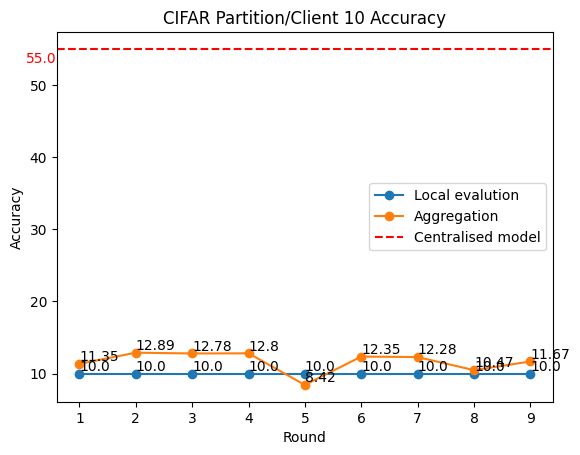

In [44]:
#plt.plot(iteration,Train_acc_result,marker='o',label="Train")
plt.title(f"CIFAR Partition/Client {NumOfPartition} Accuracy")
plt.plot(iteration,Val_acc_result,marker='o',label="Local evalution")
plt.plot(iteration,Test_acc_result,marker='o',label="Aggregation")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.xticks(iteration)

for i, j in zip(iteration, Val_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')
for i, j in zip(iteration, Test_acc_result):
    plt.text(i, j,f"{round(j,2)}", ha='left', va='bottom')

average_value = 55.00
plt.gca().text(0, average_value/60, f"{average_value}", transform=plt.gca().transAxes, ha='right',color='r',)
plt.axhline(y=average_value, color='r', linestyle='--', label='Centralised model')

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.legend()

#plt.savefig(f"MNIST_Partition_Client_{NumOfPartition}_Accuracy.png")
plt.show()